In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import operator
import itertools


In [2]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [3]:
train_dict={}
for (data, target) in train_data:
    if  target not in train_dict:
        train_dict[ target]=[]
        train_dict[ target].append(data)
    else:
        train_dict[ target].append(data)

In [4]:
initial_train_data=[]
initial_train_label=[]
for i in range(7):
    for j in range(0,10):
        initial_train_data.append(train_dict[i][j])
        initial_train_label.append(i)
    
print(initial_train_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [5]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
train_x=torch.stack([data for (data, target) in train_data])
train_label=torch.tensor([target for (data, target) in train_data])
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([70, 1, 28, 28])
torch.Size([70])


In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 20)
        
        self.prior_mu=torch.tensor(np.zeros(200), dtype=torch.float, requires_grad=False)
        self.prior_diag=torch.tensor(np.ones(200), dtype=torch.float, requires_grad=False)
        
        self.q_mu=torch.tensor(np.zeros(200), dtype=torch.float, requires_grad=True)
        self.q_diag=torch.tensor(np.ones(200), dtype=torch.float, requires_grad=True)
        params = list(self.parameters()) + [self.q_mu,self.q_diag]
        self.optimizer = optim.Adam(params, lr=0.001)
        self.feature_optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.final_optimizer = optim.Adam([ self.q_mu, self.q_diag ], lr=0.01)

    def forward(self, x, final_weight):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =self.fc2(x)
        x= torch.matmul(x,final_weight)
        return F.log_softmax(x,dim=-1)
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =  self.fc2(x)
        return x
    
    def predict(self,x):
        with torch.no_grad():
            eps=torch.tensor(np.random.normal([200]),dtype=torch.float)
            final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
            output = torch.exp(self.forward(x,final_weight_sample))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
    def test_prediction(self, x):
        with torch.no_grad():
            final_weight_mean=self.q_mu.view(20,10)
            output = torch.exp(self.forward(x,final_weight_mean))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
        
    def predictive_distribution_entropy(self,x):
        eps=torch.randn([100,200])
        #eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
        feature_of_data=self.feature_forward(x)[0]
        output_logit=final_weight_samples@feature_of_data
        output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
        
        
        sample=output_dis.sample([100]).reshape([-1,1])
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
    def predictive_distribution_entropy_2(self,x, sample_num=100):
        eps=torch.randn([sample_num,200])
        #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,200)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
        feature_of_data=self.feature_forward(x)[0]
        output_logit=final_weight_samples@feature_of_data
        output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
        
        eps=torch.randn([sample_num,200])
        #eps=torch.tensor(np.random.normal(size=[sample_num,200]),dtype=torch.float)
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,200)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
        feature_of_data=self.feature_forward(x)[0]
        output_logit=final_weight_samples@feature_of_data
        output_dis_for_sample=torch.distributions.categorical.Categorical(logits=output_logit)
        
        sample=output_dis_for_sample.sample([sample_num]).reshape([-1,1])
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
#       def lower_bound_entropy(self,x):
#         eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
#         feature_of_data=self.feature_forward(x)[0]
#         output_logit=final_weight_samples@feature_of_data
#         output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
#         sample=output_dis.sample([100]).reshape([-1,1])
        
#         eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
#         final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
        
        
        
        
        
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
    
    def online_train(self,x,label):
        train_losses = []
        total_size=x.size(0)
        curr_prior_mu = self.q_mu.clone().detach()
        curr_prior_diag= self.prior_diag.clone().detach()
        correct_flag=0

        while correct_flag<5:
            
#             lr = 0.01 * (0.1 ** (it // 2000))
#             for param_group in self.final_optimizer.param_groups:
#                 param_group['lr'] = lr
        
            self.final_optimizer.zero_grad()
            eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
            final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
            output = self.forward(x,final_weight_sample)
            nll_loss= F.nll_loss(output,label,reduction='sum')
            kl=KL_diag_gaussian(self.q_mu,self.q_diag,curr_prior_mu,curr_prior_diag)
            neg_elbo=kl+nll_loss
            neg_elbo.backward()
            self.final_optimizer.step()
            train_losses.append(neg_elbo.item())
            
            
            if output.data.max(dim=1, keepdim=True)[1].item()==label.item():
                correct_flag+=1
            else:
                correct_flag=0
        print(output.data.max(dim=1, keepdim=True)[1].item())
        plt.plot(train_losses)
        plt.show()
        
        
    
    def pre_train(self,x,label):
        train_losses = []
        batch_size=50
        for epoch in range(0,1000):
            for it in range(0,int(x.size(0)/batch_size)+1):
                index=np.random.choice(x.size(0),batch_size)
                self.optimizer.zero_grad()

    #             conditional_loss=0
    #             for i in range(0,10):
                eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
                final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
                output = self.forward(x[index],final_weight_sample)
                nll_loss= F.nll_loss(output,label[index],reduction='sum')*(float(x.size(0))/float(batch_size))
                kl=KL_diag_gaussian(self.q_mu,self.q_diag,self.prior_mu,self.prior_diag)
                neg_elbo=kl+nll_loss
                neg_elbo.backward()
                self.optimizer.step()
                train_losses.append(neg_elbo.item())
        plt.plot(train_losses)
        plt.show()
        
        
    def test(self):
        correct=0
        for data, target in test_loader:
            pred = self.predict(data)
            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ratio= float(correct)/len(test_loader.dataset)
        return correct_ratio
    

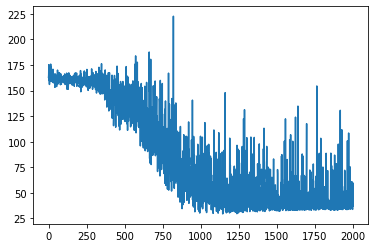

In [19]:
active_bnn = Net()
active_bnn.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [20]:
# print(active_bnn.test_prediction(initial_train_data_tensor))
# # print(active_bnn.predict(initial_train_data_tensor))
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))
print('yo')
print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.3455, grad_fn=<NegBackward>)
tensor(1.6826, grad_fn=<NegBackward>)
tensor(1.0595, grad_fn=<NegBackward>)
tensor(0.2753, grad_fn=<NegBackward>)
tensor(0.2354, grad_fn=<NegBackward>)
tensor(0.3282, grad_fn=<NegBackward>)
tensor(0.3117, grad_fn=<NegBackward>)
tensor(1.3336, grad_fn=<NegBackward>)
tensor(0.5853, grad_fn=<NegBackward>)
yo
tensor(0.4495, grad_fn=<NegBackward>)
tensor(1.7317, grad_fn=<NegBackward>)
tensor(0.9717, grad_fn=<NegBackward>)
tensor(0.3632, grad_fn=<NegBackward>)
tensor(0.4759, grad_fn=<NegBackward>)
tensor(0.5969, grad_fn=<NegBackward>)
tensor(0.4826, grad_fn=<NegBackward>)
tensor(1.3139, grad_fn=<NegBackward>)
tensor(0.6764, grad_fn=<NegBackward>)


8


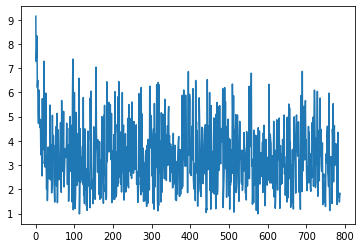

In [21]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn.online_train(x_new,label_new)

In [25]:
print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.5765, grad_fn=<NegBackward>)
tensor(1.8804, grad_fn=<NegBackward>)
tensor(1.4947, grad_fn=<NegBackward>)
tensor(0.9026, grad_fn=<NegBackward>)
tensor(0.9752, grad_fn=<NegBackward>)
tensor(0.6144, grad_fn=<NegBackward>)
tensor(0.5462, grad_fn=<NegBackward>)
tensor(1.5486, grad_fn=<NegBackward>)
tensor(0.7825, grad_fn=<NegBackward>)


8


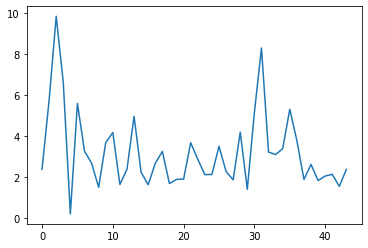

In [23]:
x_new=train_dict[8][21].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn.online_train(x_new,label_new)

In [26]:
print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15]))

tensor(0.7990, grad_fn=<NegBackward>)
tensor(1.8585, grad_fn=<NegBackward>)
tensor(1.3732, grad_fn=<NegBackward>)
tensor(1.0295, grad_fn=<NegBackward>)
tensor(1.1430, grad_fn=<NegBackward>)
tensor(0.9648, grad_fn=<NegBackward>)
tensor(0.5950, grad_fn=<NegBackward>)
tensor(1.4060, grad_fn=<NegBackward>)
tensor(0.9643, grad_fn=<NegBackward>)


8


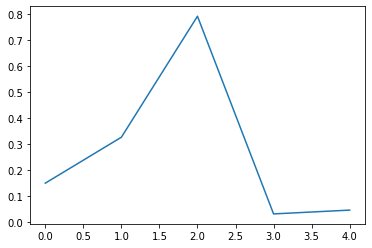

In [13]:
x_new=train_dict[8][20].view(-1,1,28,28)
label_new=torch.tensor([8])

active_bnn.online_train(x_new,label_new)

In [14]:
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))

tensor(1.2451, grad_fn=<NegBackward>)
tensor(1.5054, grad_fn=<NegBackward>)
tensor(1.6477, grad_fn=<NegBackward>)
tensor(1.0174, grad_fn=<NegBackward>)
tensor(1.2026, grad_fn=<NegBackward>)
tensor(1.0648, grad_fn=<NegBackward>)
tensor(1.0513, grad_fn=<NegBackward>)
tensor(1.8491, grad_fn=<NegBackward>)
tensor(0.8741, grad_fn=<NegBackward>)


In [15]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))

0
tensor(0.9127, grad_fn=<NegBackward>)
tensor(1.8014, grad_fn=<NegBackward>)
1
tensor(0.8220, grad_fn=<NegBackward>)
tensor(1.5056, grad_fn=<NegBackward>)
2
tensor(1.0006, grad_fn=<NegBackward>)
tensor(1.9042, grad_fn=<NegBackward>)
3
tensor(0.8793, grad_fn=<NegBackward>)
tensor(1.9543, grad_fn=<NegBackward>)
4
tensor(1.0551, grad_fn=<NegBackward>)
tensor(1.8501, grad_fn=<NegBackward>)
5
tensor(1.0359, grad_fn=<NegBackward>)
tensor(2.0544, grad_fn=<NegBackward>)
6
tensor(0.9988, grad_fn=<NegBackward>)
tensor(1.8319, grad_fn=<NegBackward>)
7
tensor(1.3137, grad_fn=<NegBackward>)
tensor(1.7933, grad_fn=<NegBackward>)
8
tensor(1.0005, grad_fn=<NegBackward>)
tensor(1.4839, grad_fn=<NegBackward>)
9
tensor(1.0876, grad_fn=<NegBackward>)
tensor(1.2105, grad_fn=<NegBackward>)
10
tensor(1.0646, grad_fn=<NegBackward>)
tensor(1.7062, grad_fn=<NegBackward>)
11
tensor(0.7961, grad_fn=<NegBackward>)
tensor(1.6254, grad_fn=<NegBackward>)
12
tensor(0.9257, grad_fn=<NegBackward>)
tensor(1.6366, grad_f

8


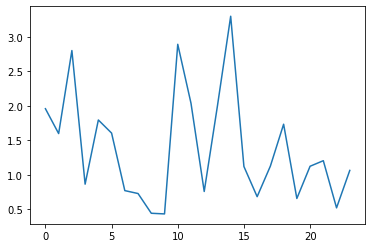

8


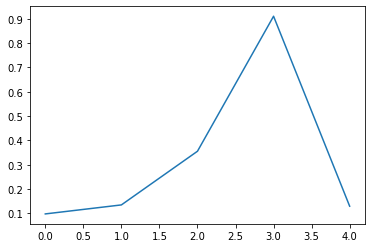

8


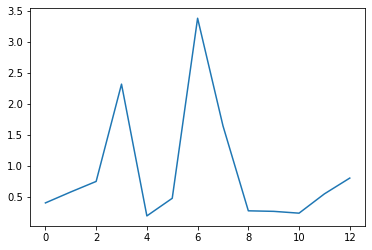

8


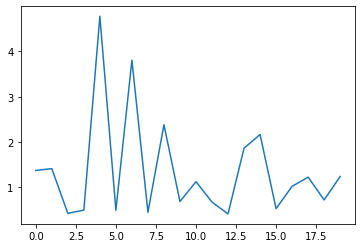

8


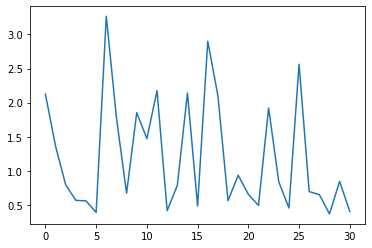

8


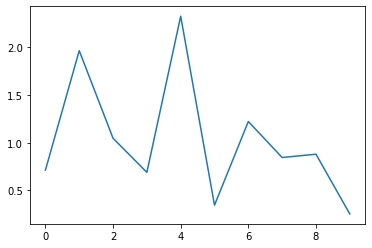

8


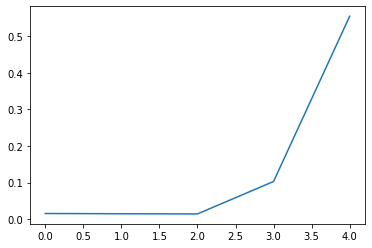

8


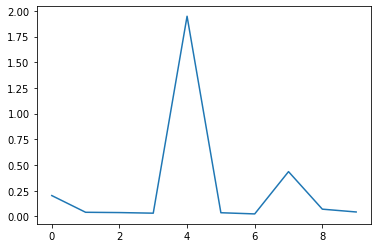

8


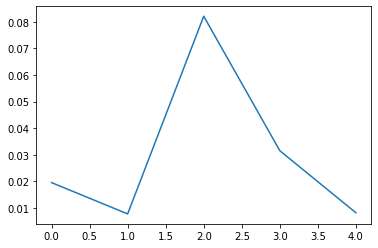

8


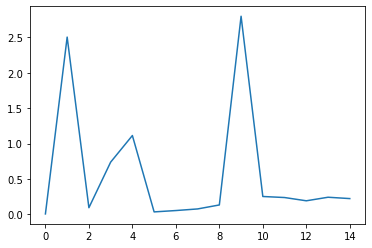

8


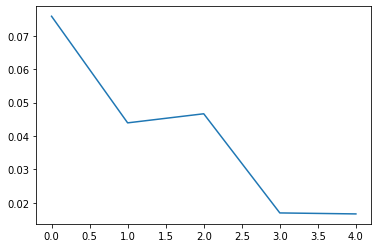

8


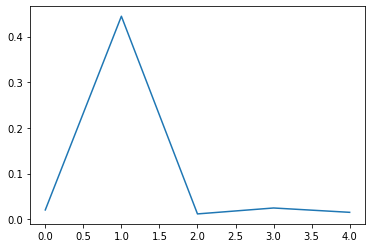

8


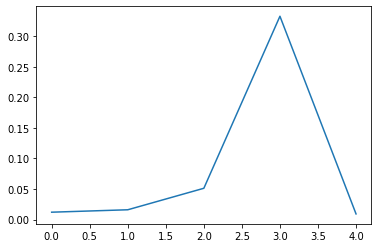

8


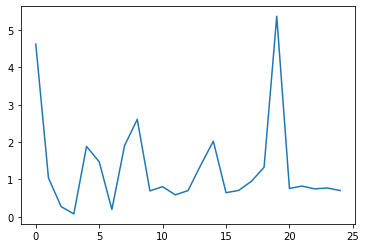

8


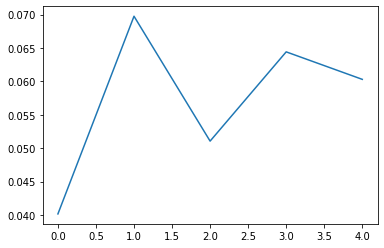

8


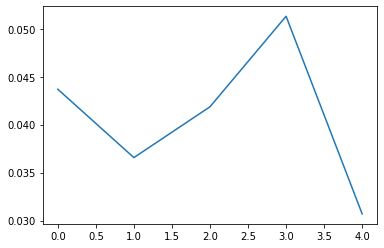

8


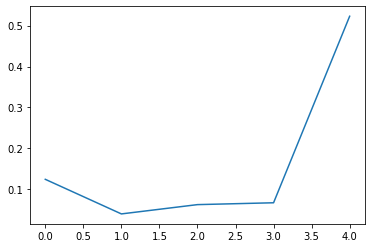

8


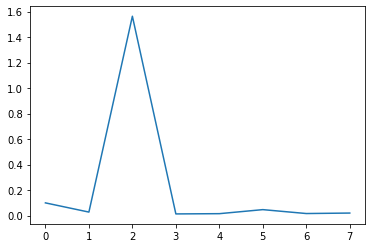

8


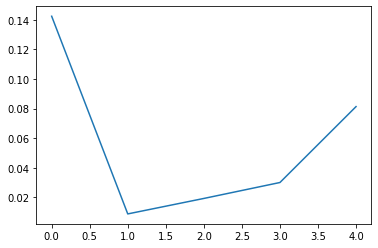

8


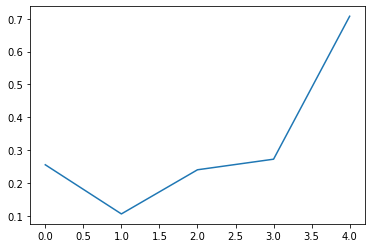

8


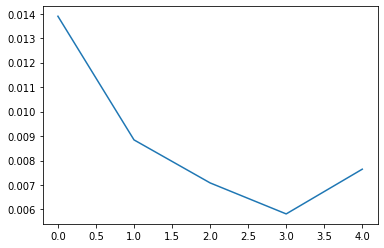

8


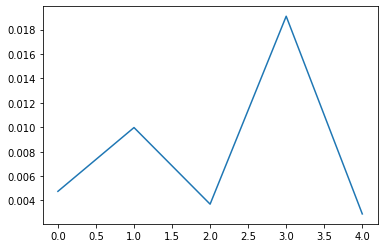

8


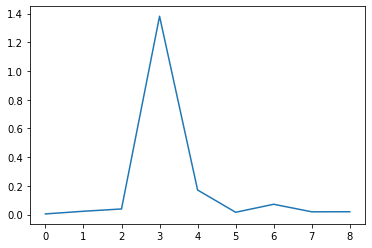

8


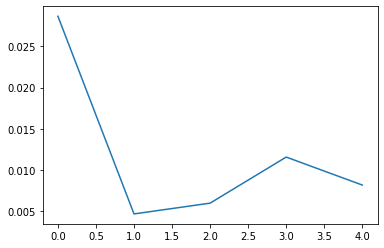

8


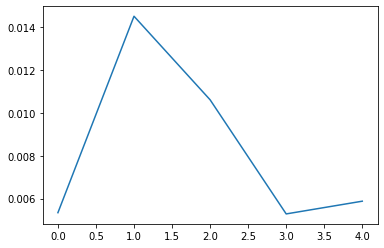

8


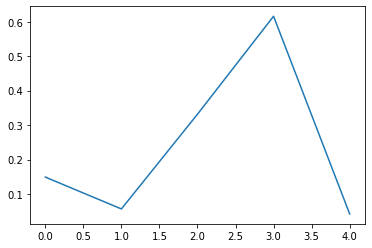

8


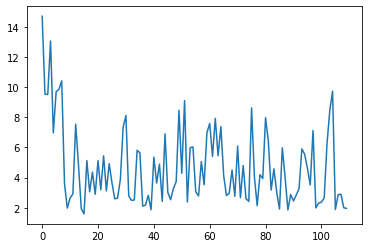

8


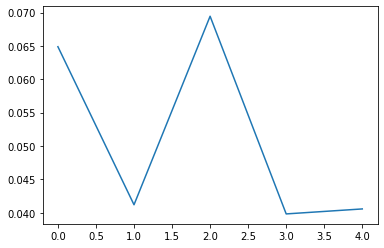

8


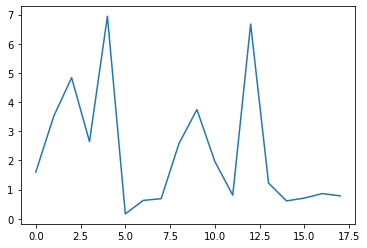

8


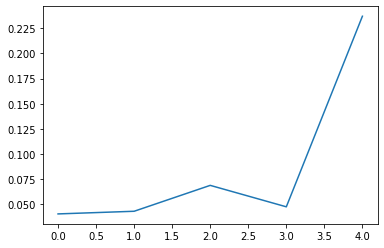

In [16]:
for i in range(0,30):
    x_new=train_dict[8][i].view(-1,1,28,28)
    label_new=torch.tensor([8])

    active_bnn.online_train(x_new,label_new)

In [17]:
for i in range(0,30):
    print(i)
    print(active_bnn.predictive_distribution_entropy(train_dict[1][i]))
    print(active_bnn.predictive_distribution_entropy(train_dict[8][i]))

0
tensor(1.1103, grad_fn=<NegBackward>)
tensor(0.7282, grad_fn=<NegBackward>)
1
tensor(1.4160, grad_fn=<NegBackward>)
tensor(0.4577, grad_fn=<NegBackward>)
2
tensor(1.3003, grad_fn=<NegBackward>)
tensor(0.1568, grad_fn=<NegBackward>)
3
tensor(1.4239, grad_fn=<NegBackward>)
tensor(0.2489, grad_fn=<NegBackward>)
4
tensor(1.0231, grad_fn=<NegBackward>)
tensor(0.3109, grad_fn=<NegBackward>)
5
tensor(1.1915, grad_fn=<NegBackward>)
tensor(0.5928, grad_fn=<NegBackward>)
6
tensor(1.3255, grad_fn=<NegBackward>)
tensor(0.0313, grad_fn=<NegBackward>)
7
tensor(0.9904, grad_fn=<NegBackward>)
tensor(0.0931, grad_fn=<NegBackward>)
8
tensor(1.1098, grad_fn=<NegBackward>)
tensor(0.0375, grad_fn=<NegBackward>)
9
tensor(1.3215, grad_fn=<NegBackward>)
tensor(1.2753, grad_fn=<NegBackward>)
10
tensor(1.1837, grad_fn=<NegBackward>)
tensor(0.0335, grad_fn=<NegBackward>)
11
tensor(1.0946, grad_fn=<NegBackward>)
tensor(0.0984, grad_fn=<NegBackward>)
12
tensor(1.2853, grad_fn=<NegBackward>)
tensor(0.0503, grad_f